In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import time
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image  # Importe a classe Image da biblioteca PIL
import torch.optim as optim
import os

In [2]:
%%bash
#ls /drive/My/ Drive/cancer_identifier/base/bach/Photos/bach_bach/

Couldn't find program: 'bash'


In [3]:
PATH='C:/Users/Karol/Documents/Python projeto/Bases/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/BACH_Preparado/32x32_pb'

# PATH='/drive/My Drive/cancer_identifier/base/bach/Photos/bach_bach/BACH_Preparado/200x200_pb'

In [4]:

transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])




batch_size = 4


In [5]:
dataset = ImageFolder(PATH, transform=transform)

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

In [7]:
classes = ('Benign', 'InSitu', 'Invasive', 'Normal')

In [8]:
#parâmetros para a rede
#tam_entrada=100
#tam_interm_1=100
#tam_interm_2=100
#epochs = 100

In [9]:
def imshow(img):
    img = (img * 0.5) + 0.5  # desnormalizar imagens
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

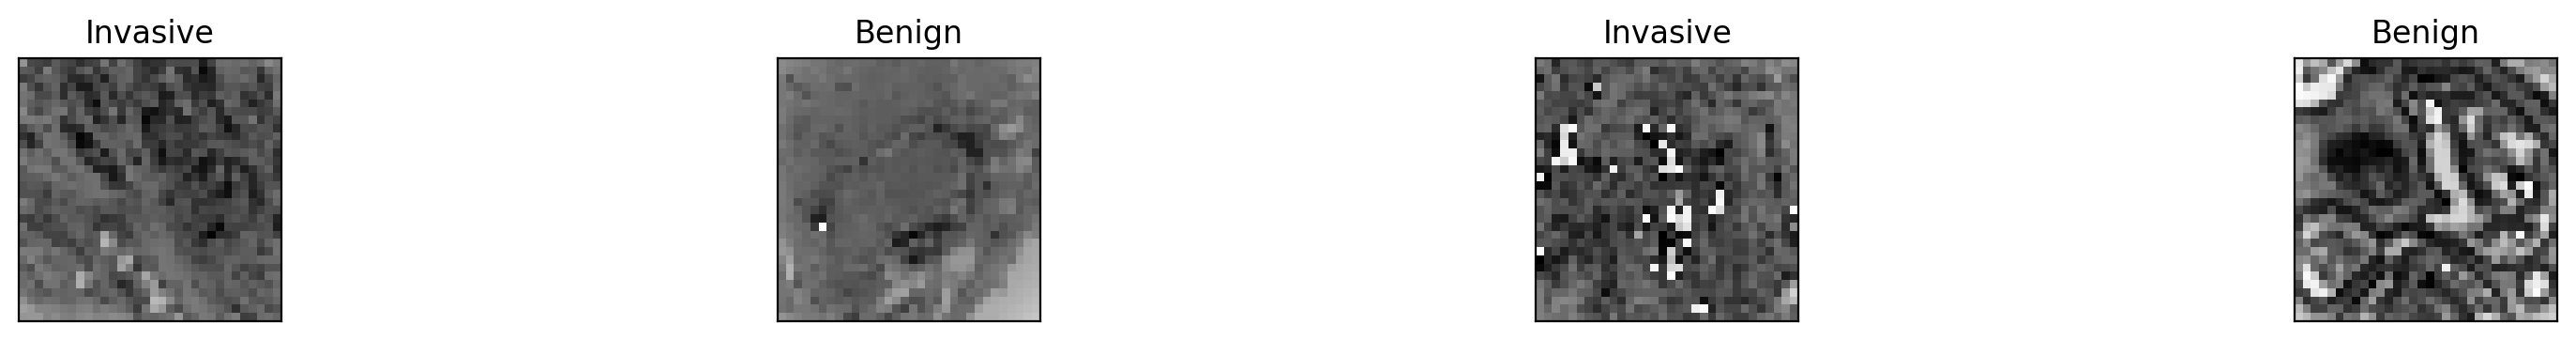

In [10]:
# Um batch de dados de treino
dataiter = iter(dataloader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 8 // 2, idx + 1, xticks=[], yticks=[])  # Correção na divisão
    image = images[idx].numpy().transpose((1, 2, 0))  # Reorganize as dimensões da imagem
    image_pil = Image.fromarray((image * 255).astype(np.uint8))  # Converte para objeto PIL
    plt.imshow(image_pil)  # Exibe a imagem PIL
    ax.set_title(classes[labels[idx]])

plt.show()

In [11]:
images[0].shape

torch.Size([3, 32, 32])

In [12]:
labels

tensor([2, 0, 2, 0])

In [13]:
inicio = time.time()
fim = time.time()

In [14]:
print (fim - inicio)

0.0


Para calcular o tamanho espacial da saida podemos usar a fórmula ((N − F + 2P) / S) + 1.
onde:
N : Dimensão da imagem de entrada
F : Dimensão do Filtro
P : O padding
S : O stride
Lembrando que um maxpooling de (kernel_size = 2,stride = 2) diminui pela metade a dimensão da imagem nos eixos x e y


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

# Definição da rede neural
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # Aumentado o número de filtros para 32
        self.pool = nn.MaxPool2d(2, 2)    # Max Pooling com kernel 2x2
        self.conv2 = nn.Conv2d(32, 64, 5) # Aumentado o número de filtros para 64
        self.fc1 = nn.Linear(64 * 5 * 5, 256)  # Ajustado o tamanho da entrada para 64 * 5 * 5 e aumentado para 256 neurônios
        self.dropout = nn.Dropout(p=0.5)  # Dropout para regularização
        self.fc2 = nn.Linear(256, 128)  # Segunda camada totalmente conectada com 128 neurônios
        self.fc3 = nn.Linear(128, 4)    # 4 classes de saída: Benign, InSitu, Invasive, Normal

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))  # Usando Leaky ReLU ao invés de ReLU
        x = self.pool(F.leaky_relu(self.conv2(x)))  # Segunda camada convolucional com Leaky ReLU
        x = torch.flatten(x, 1)  # Achatar as dimensões para passar para a camada linear
        x = F.leaky_relu(self.fc1(x))  # Primeira camada totalmente conectada com Leaky ReLU
        x = self.dropout(x)            # Aplicar Dropout
        x = F.leaky_relu(self.fc2(x))  # Segunda camada totalmente conectada com Leaky ReLU
        x = self.fc3(x)  # Camada de saída (sem ativação aqui porque será usada no critério de perda)
        return x

cnn = CNN()

In [16]:
#Caso esteja disponível, processar na GPU
USAR_GPU = False

In [17]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)



#train_loader=torch.utils.data.DataLoader(dataset, batch_size=100)
# optimizer = optim.Adam(cnn.parameters(), lr=0.01)


In [18]:
use_cuda = USAR_GPU and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print('Usar GPU: ', USAR_GPU)
print('GPU disponivel:', torch.cuda.is_available())
print('Processando em:', device )

#Seta onde será executada
cnn.to(device)

Usar GPU:  False
GPU disponivel: False
Processando em: cpu


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [19]:
x=[]
y_acertos=[]
y_loss=[]
epochs = 100
inicio = time.time()



for epoch in range(epochs):
    total_loss = 0
    total_acertos = 0

    k=0

    for images, labels in dataloader:
       #Coloca os dados no dispositivo de processamento
       images, labels = images.to(device), labels.to(device)
       preds = cnn(images)
       loss = F.cross_entropy(preds, labels)

       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

       acertos = preds.argmax(dim=1).eq(labels).sum().item()
       total_loss+=loss.item()
       total_acertos+=acertos

    print('epoch:', epoch, end='')
    print('\tloss: ',round(total_loss, 2), end='')
    print('\tacertos:', total_acertos, f'({round(total_acertos*100/len(dataset), 2)}%)')

    x.append(epoch)
    y_acertos.append(total_acertos)
    y_loss.append(total_loss)

fim = time.time()
tempo = round(fim - inicio, 2)
minutos = tempo // 60
segundos = round (tempo % 60,2)
print(minutos,'minutos e' , segundos, 'segundos' )
print(tempo, 'segundos')


from unittest import main, TestCase
import unittest



epoch: 0	loss:  140.39	acertos: 88 (21.95%)
epoch: 1	loss:  140.14	acertos: 91 (22.69%)
epoch: 2	loss:  140.08	acertos: 113 (28.18%)
epoch: 3	loss:  140.04	acertos: 105 (26.18%)
epoch: 4	loss:  139.99	acertos: 94 (23.44%)
epoch: 5	loss:  139.92	acertos: 100 (24.94%)
epoch: 6	loss:  139.99	acertos: 100 (24.94%)
epoch: 7	loss:  139.93	acertos: 107 (26.68%)
epoch: 8	loss:  139.87	acertos: 115 (28.68%)
epoch: 9	loss:  139.73	acertos: 123 (30.67%)
epoch: 10	loss:  139.75	acertos: 109 (27.18%)
epoch: 11	loss:  139.75	acertos: 124 (30.92%)
epoch: 12	loss:  139.58	acertos: 114 (28.43%)
epoch: 13	loss:  139.53	acertos: 124 (30.92%)
epoch: 14	loss:  139.54	acertos: 123 (30.67%)
epoch: 15	loss:  139.33	acertos: 112 (27.93%)
epoch: 16	loss:  139.07	acertos: 124 (30.92%)
epoch: 17	loss:  139.16	acertos: 126 (31.42%)
epoch: 18	loss:  138.7	acertos: 147 (36.66%)
epoch: 19	loss:  138.46	acertos: 138 (34.41%)
epoch: 20	loss:  137.61	acertos: 148 (36.91%)
epoch: 21	loss:  137.51	acertos: 145 (36.16%)
ep

In [20]:
# Após o treinamento, salve os pesos do modelo
model_save_path = 'C:/Users/Karol/Documents/GitHub/python_analysis/modelo.pth'
torch.save(cnn.state_dict(), model_save_path)

In [21]:

model_path = './model/'
file_name = 'cnn_model.pth'

if not os.path.exists(model_path):
        os.makedirs(model_path)

torch.save(cnn.state_dict(), model_path + file_name)

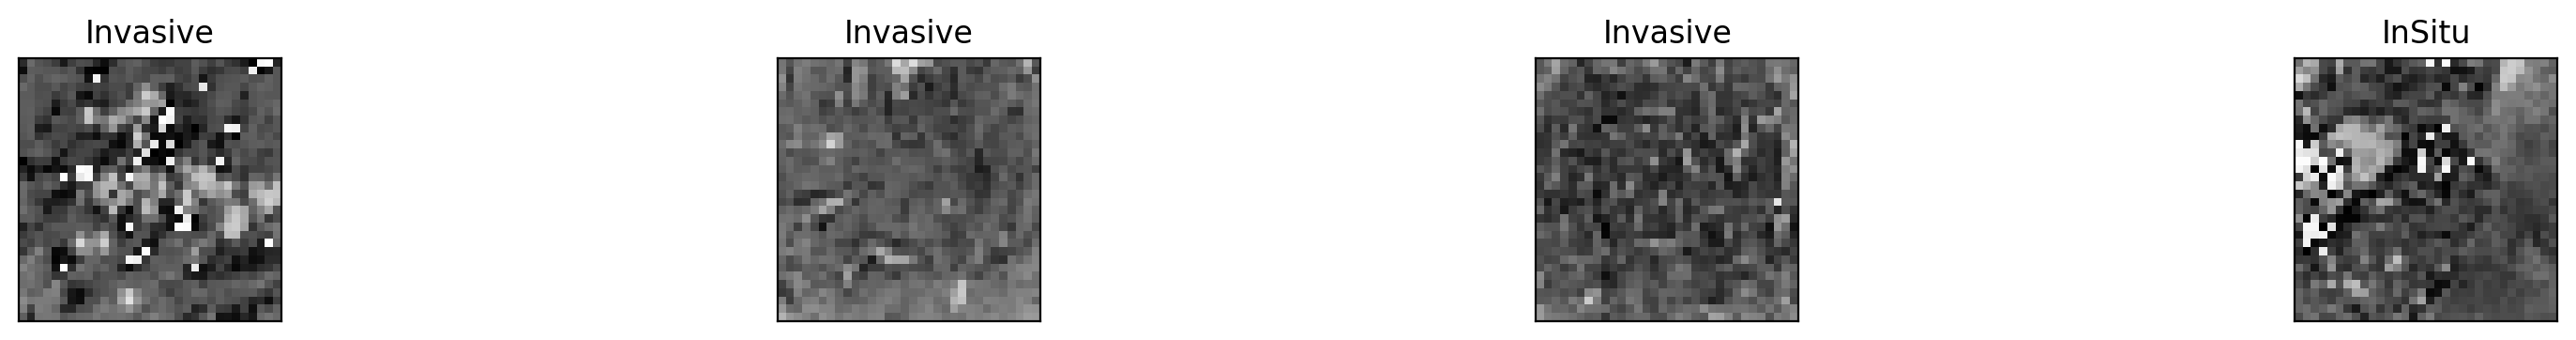

In [22]:
# Um batch de dados de treino
dataiter = iter(dataloader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 8 // 2, idx + 1, xticks=[], yticks=[])  # Correção na divisão
    image = images[idx].numpy().transpose((1, 2, 0))  # Reorganize as dimensões da imagem
    image_pil = Image.fromarray((image * 255).astype(np.uint8))  # Converte para objeto PIL
    plt.imshow(image_pil)  # Exibe a imagem PIL
    ax.set_title(classes[labels[idx]])

plt.show()

In [23]:
cnn = CNN()
cnn.load_state_dict(torch.load(model_path + file_name))

C:\Users\Karol\AppData\Local\Temp\ipykernel_18768\930375975.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load(model_path + file_name))


<All keys matched successfully>

In [24]:
outputs = cnn(images)
outputs

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  Invasive Invasive Invasive InSitu


In [25]:
correct = 0
total = 0
# nao precisamos calcular os valores de gradiente pq não estamos treinando
with torch.no_grad():
    for data in dataloader:
        images, labels = data
        outputs = cnn(images)
        # a classe com a maior energia é o que escolhemos como previsão
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 99 %


In [26]:
# contar as previsões para cada aula
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# novamente sem gradientes necessários
with torch.no_grad():
    for data in dataloader:
        images, labels = data
        outputs = cnn(images)
        _, predictions = torch.max(outputs, 1)
        # calcula predições corretas para cada classe
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print acurácia para cada classe
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

#class TestSquare(TestCase):
 # def test_classe(self):
  #      result = accuracy
   #     expected = 90.0
    #    self.assertEqual(result, expected)
     #   print(classname, accuracy)
#if __name__ == '__main__':
 # s = unittest.TestLoader().loadTestsFromTestCase(TestSquare)
  #unittest.TextTestRunner().run(s)



Accuracy for class Benign is: 100.0 %
Accuracy for class InSitu is: 100.0 %
Accuracy for class Invasive is: 100.0 %
Accuracy for class Normal is: 99.0 %


- Porcentagem % -  método para testar,
para saber a porcentagem para validar se
está acima ou abaixo do limite estipulado

- E quantidade de acertos em número

- Validar se está passando por
todas as imagens

- Validar a acurácia de cada tipo
 ('Benign', 'InSitu', 'Invasive', 'Normal')
e ver qual tipo teve maior acerto


In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

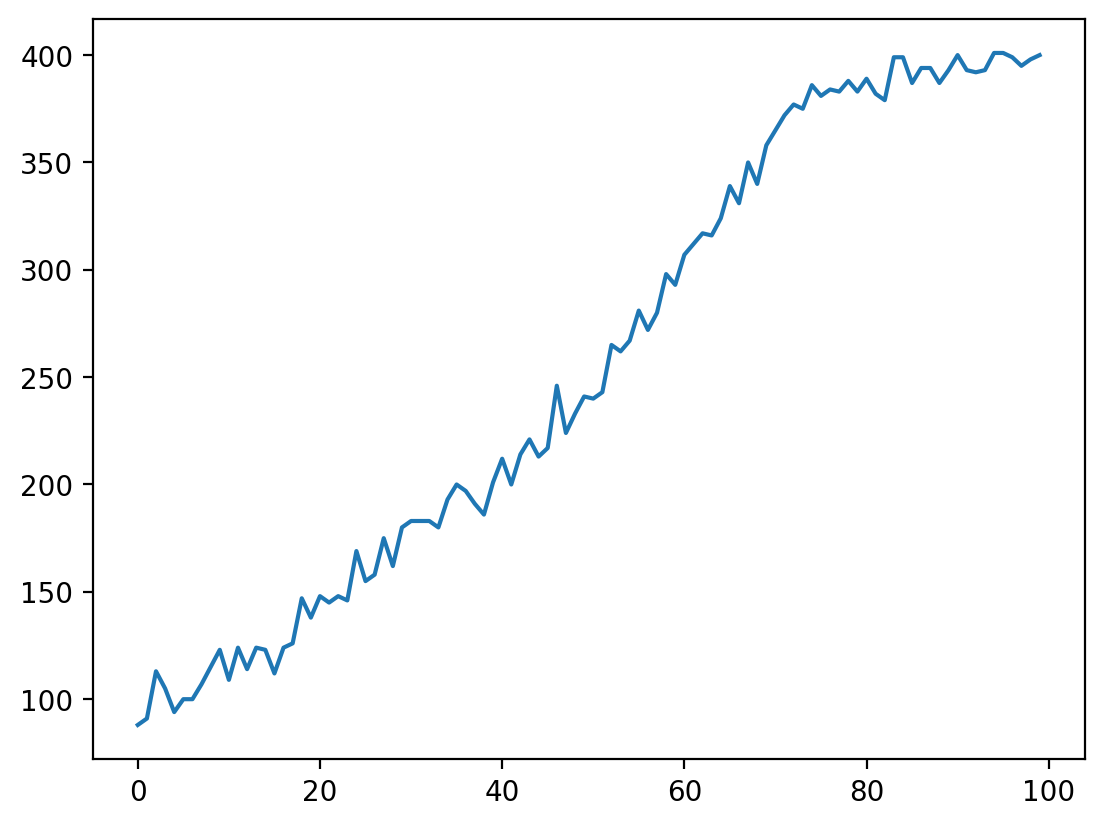

In [28]:
plt.plot(x,y_acertos)
#plt.ylim(bottom=0)
plt.show()

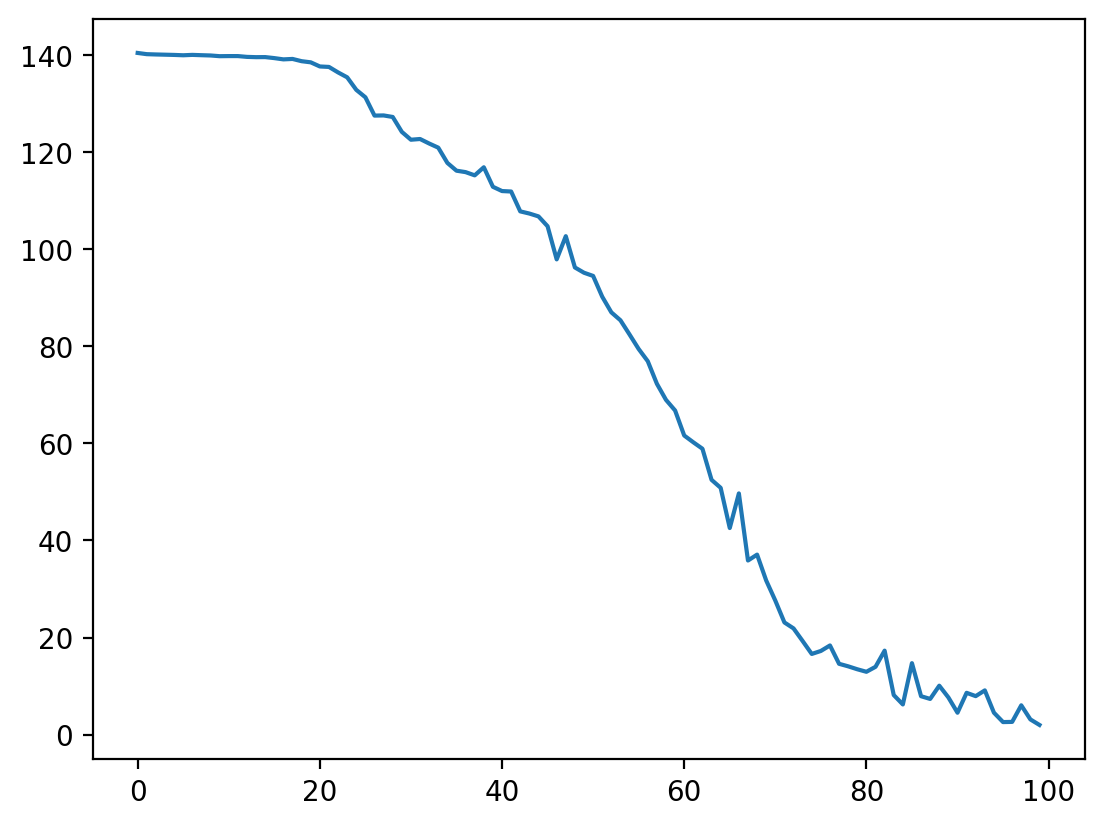

In [29]:
plt.plot(x,y_loss)
#plt.ylim(bottom=0)
plt.show()

# Referências

## Outros materiais
[CNN Training with Code Example - Neural Network Programming Course (EN)](https://www.youtube.com/watch?v=0VCOG8IeVf8&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG&index=25)  
[CNN Training Loop Explained - Neural Network Code Project (EN)](https://www.youtube.com/watch?v=XfYmia3q2Ow&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG&index=26)  




In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

def predict_single_image(image_tensor, model):
    model.eval()  
    with torch.no_grad():  
        image_tensor = image_tensor.to(device)  
        output = model(image_tensor)  
        _, predicted = torch.max(output, 1)  
        return predicted.item()  

# Caminho da imagem para a qual queremos fazer a previsão
image_path = 'C:/Users/Karol/Documents/Python projeto/Bases/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/BACH_Preparado/200x200/Invasive/iv001.tif'

image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  


model_path = 'C:/Users/Karol/Documents/GitHub/python_analysis'  
file_name = 'modelo.pth'  

cnn = CNN() 
cnn.load_state_dict(torch.load(os.path.join(model_path, file_name)))  
cnn = cnn.to(device) 

# Prever a classe da imagem
predicted_class = predict_single_image(image_tensor, cnn)

classes = ['Benign', 'InSitu', 'Invasive', 'Normal']  

# Imprimir a classe prevista
print('Classe prevista:', classes[predicted_class])


Classe prevista: Invasive


C:\Users\Karol\AppData\Local\Temp\ipykernel_18768\884972559.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load(os.path.join(model_path, file